In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split

from mapie.conformity_scores.residual_conformity_scores import GPConformityScore
from mapie.regression import MapieRegressor
from wrappers import GpOTtoSklearnChooseKernel


plt.rcParams["figure.dpi"]=300
%load_ext autoreload
%autoreload 2


/var/folders/7d/cdjx7c6d3xx42wdw5bnrmmb80000gn/T/ipykernel_46465/3634098511.py:3: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.22.3)
  import scipy


In [2]:
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"]}
plt.rcParams.update(params)

In [3]:
BLUE = np.array([[26, 54, 105]]) / 255
ORANGE = np.array([[223, 84, 49]]) / 255
YELLOW = np.array([[242, 188, 64]]) / 255


In [4]:
def g(x, discontinuity=1):
    x_return = np.array(x)
    
    # -x if x < 0 else sin(x)
    indices_negative = x_return < discontinuity
    indices_positive = x_return >= discontinuity
    x_return[indices_negative] = -x_return[indices_negative]
    x_return[indices_positive] = np.sin(x_return[indices_positive])

    return x_return

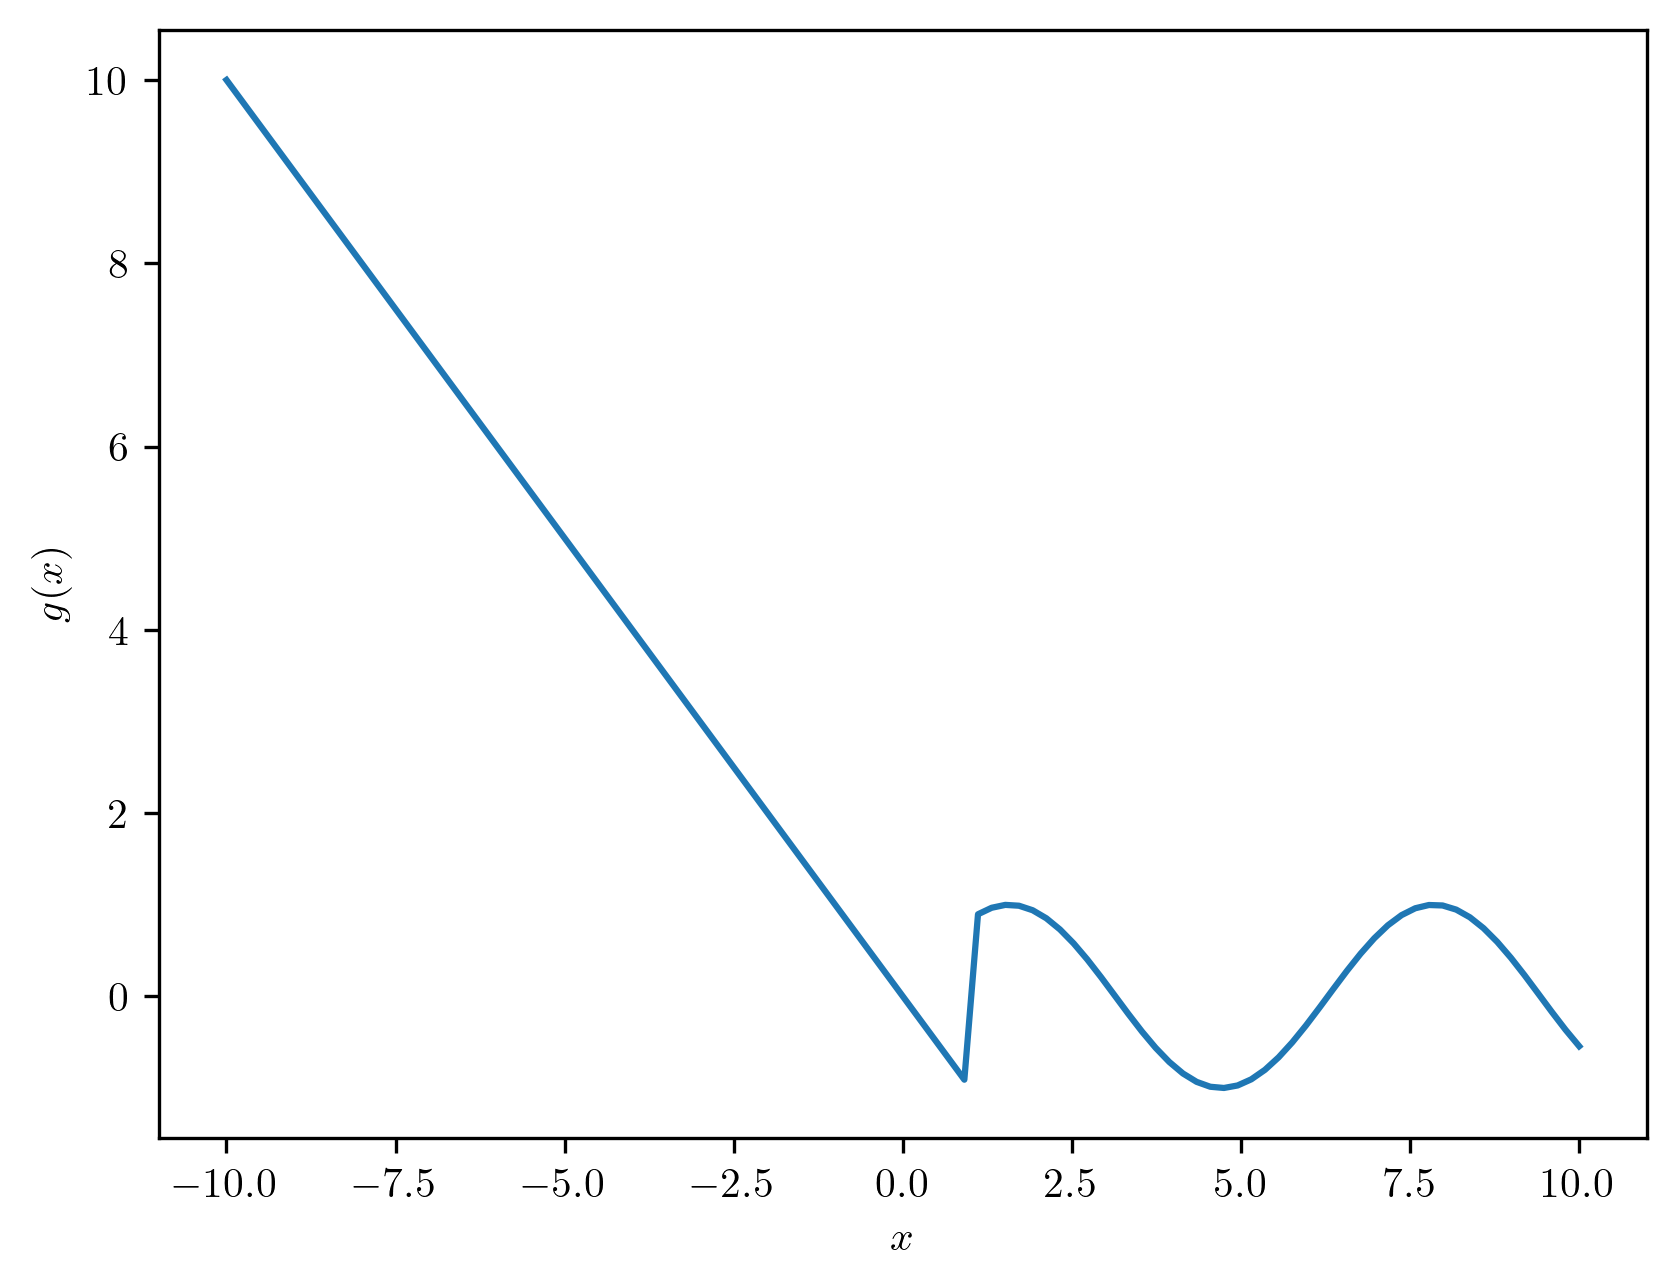

In [5]:
x_mesh = np.linspace(-10, 10, 100)
plt.plot(x_mesh, g(x_mesh))
plt.xlabel("$x$")
plt.ylabel("$g(x)$")
plt.savefig("../plots/toy_function_disc.png")


In [6]:
X_train, X_test, y_train, y_test = train_test_split(x_mesh, g(x_mesh), test_size=.9, random_state=42)
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
x_test_indices = np.argsort(X_test[:, 0])
X_test = X_test[x_test_indices]
y_test = y_test[x_test_indices]

In [7]:
print(
    f"  N training points = {len(X_train)}\n",
    f" N testing points = {len(X_test)}"
)

  N training points = 10
  N testing points = 90


In [8]:
gp = GpOTtoSklearnChooseKernel(trend="Constant", kernel="SqExp", dimension=1)

In [9]:
gp.fit(X_train, y_train)

WRN - Warning! For coherency we set scale upper bounds = [31.5152]


# Fit and Predict with MAPIE

In [10]:
mapie_j_plus_gp = MapieRegressor(
    estimator=gp,
    cv=-1,
    method="plus",
    conformity_score=GPConformityScore(),
    model_has_std=True,
    random_state=42
)

mapie_j_plus = MapieRegressor(
    estimator=gp,
    cv=-1,
    method="plus",
    conformity_score=None,
    model_has_std=False,
    random_state=42
)


mapie_j_plus_gp.fit(X_train, y_train)
mapie_j_plus.fit(X_train, y_train)


WRN - (previous message repeated 8 times)
WRN - Warning! For coherency we set scale upper bounds = [29.0909]
WRN - Warning! For coherency we set scale upper bounds = [31.1111]
WRN - Warning! For coherency we set scale upper bounds = [31.5152]
WRN - (previous message repeated 8 times)
WRN - Warning! For coherency we set scale upper bounds = [29.0909]
WRN - Warning! For coherency we set scale upper bounds = [31.1111]
WRN - Warning! For coherency we set scale upper bounds = [31.5152]


MapieRegressor(cv=-1,
               estimator=GpOTtoSklearnChooseKernel(dimension=1, kernel='SqExp',
                                                   trend='Constant'),
               random_state=42)

In [11]:
ALPHA = .1

_, y_pss_j_plus_gp = mapie_j_plus_gp.predict(X_test, alpha=ALPHA)
_, y_pss_j_plus = mapie_j_plus.predict(X_test, alpha=ALPHA)

y_mean, y_std = gp.predict(X_test, return_std=True)

In [12]:
q_alpha_min = scipy.stats.norm.ppf(ALPHA / 2)
q_alpha_max = scipy.stats.norm.ppf(1 - ALPHA / 2)

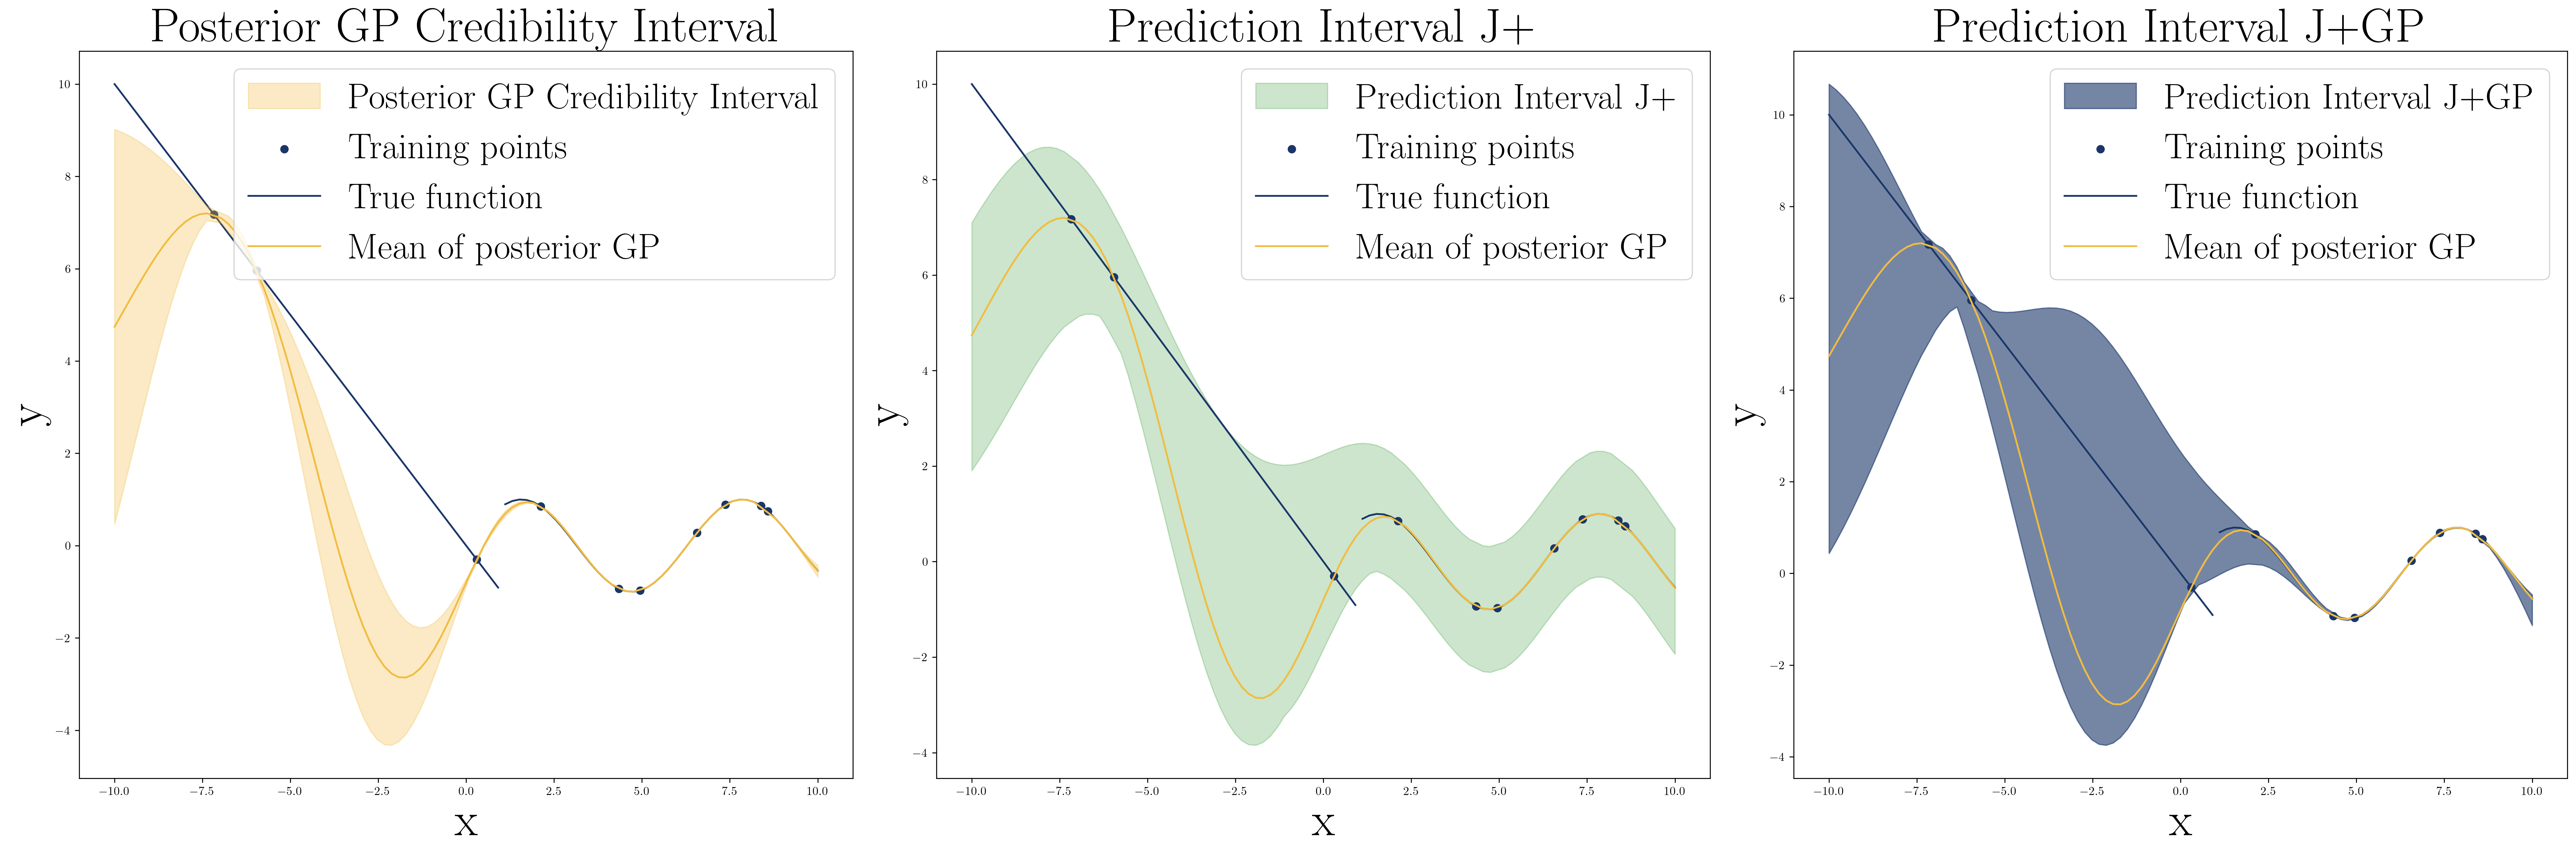

In [13]:
f, ax = plt.subplots(1, 3, figsize=(30, 10))

ax[0].fill_between(
        X_test[:, 0],
        y_mean + y_std * q_alpha_min,
        y_mean + y_std * q_alpha_max,
        alpha=0.3,
        color=YELLOW,
        label= "Posterior GP Credibility Interval",
        zorder=5
    )

ax[1].fill_between(
        X_test[:, 0],
        y_pss_j_plus[:, 0, 0],
        y_pss_j_plus[:, 1, 0],
        alpha=.2,
        color="g",
        label="Prediction Interval J+",
    )
ax[2].fill_between(
        X_test[:, 0],
        y_pss_j_plus_gp[:, 0, 0],
        y_pss_j_plus_gp[:, 1, 0],
        alpha=.6,
        color=BLUE,
        label="Prediction Interval J+GP",
    )

for i in range(3):
    ax[i].scatter(X_train, y_train, c=BLUE, label="Training points")
    ax[i].plot(x_mesh[x_mesh <= 1], g(x_mesh)[x_mesh <= 1], c=BLUE, label="True function")
    ax[i].plot(x_mesh[x_mesh > 1], g(x_mesh)[x_mesh > 1], c=BLUE)
    ax[i].plot(X_test, y_mean, c=YELLOW, label="Mean of posterior GP")
    ax[i].set_xlabel("x", fontsize=40)
    ax[i].set_ylabel("y", fontsize=40)


ax[0].legend(fontsize=30)
ax[1].legend(fontsize=30)
ax[2].legend(fontsize=30)

ax[0].set_title("Posterior GP Credibility Interval", fontsize=40)
ax[1].set_title("Prediction Interval J+", fontsize=40)
ax[2].set_title("Prediction Interval J+GP", fontsize=40)

plt.tight_layout()
plt.savefig("../plots/intervals_toy_function_disc.pdf")
